In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as tF
import torchmetrics.functional as tmF

/opt/homebrew/anaconda3/envs/segmenting-subsurface-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
volume_path = os.path.join(os.pardir, 'data', 'raw', 'train', '69764103', 'horizon_labels_block-2_vol_69764103.npy')
volume = np.load(volume_path, allow_pickle=True)
slice = volume[0, :, :].T
slice = torch.from_numpy(slice).to(dtype=torch.int64)

num_classes = 20

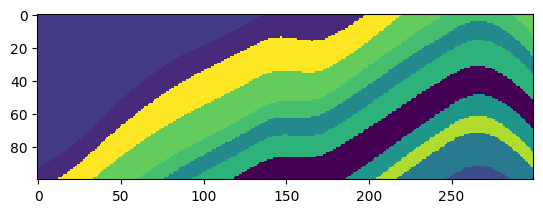

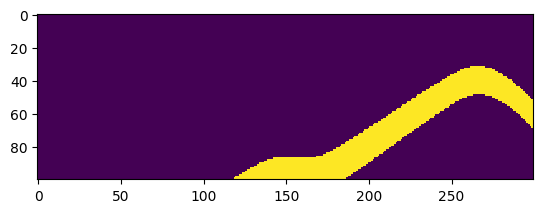

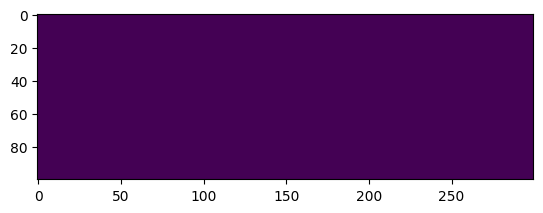

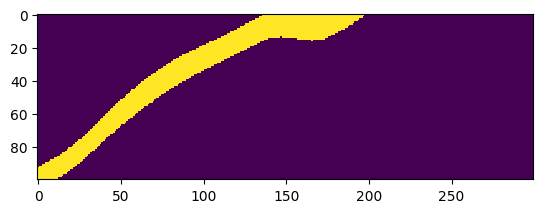

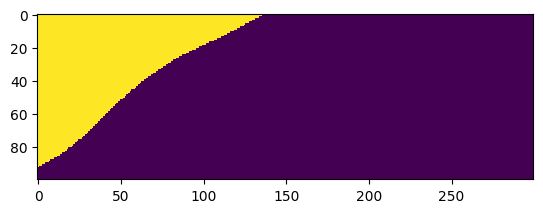

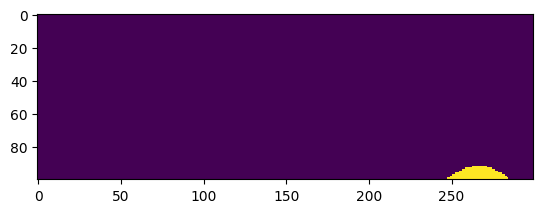

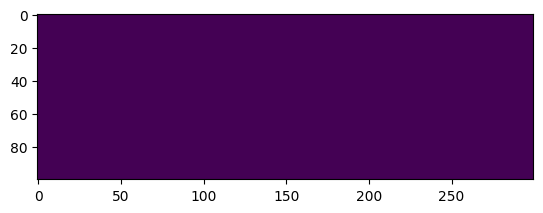

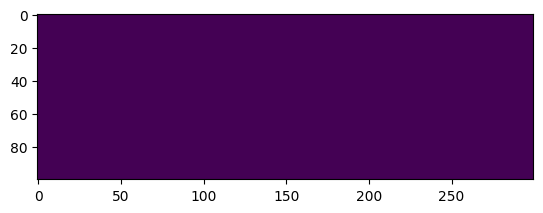

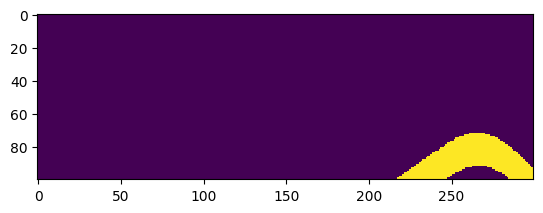

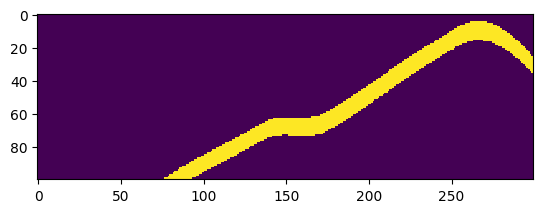

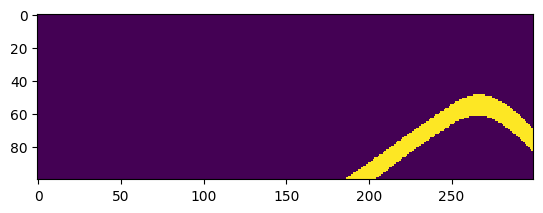

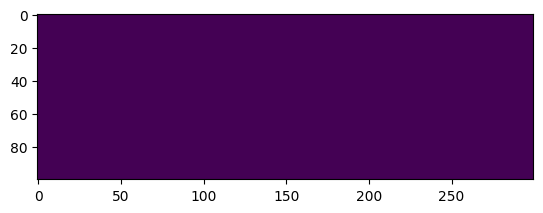

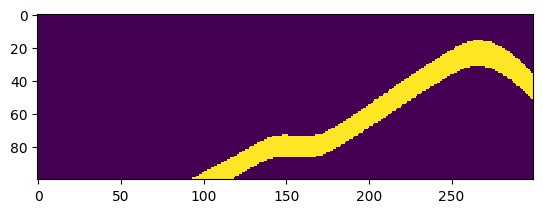

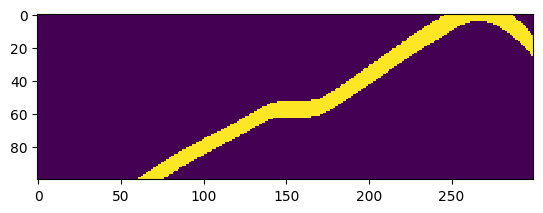

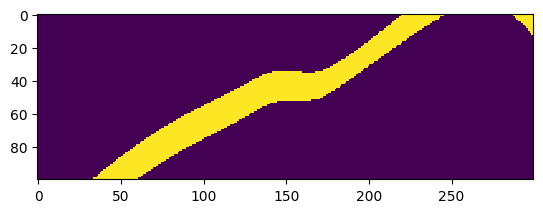

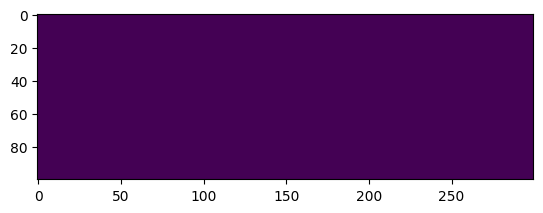

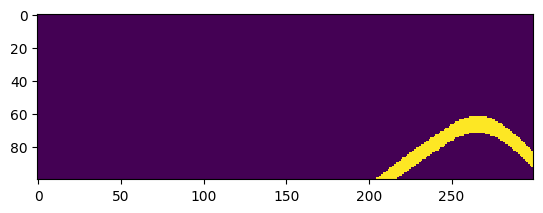

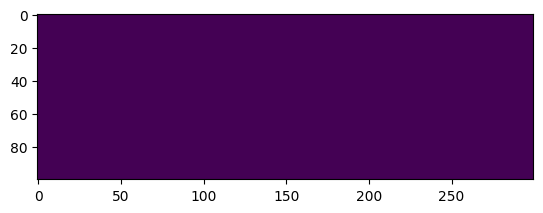

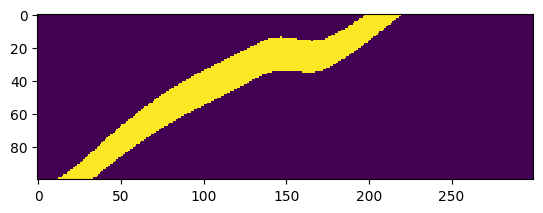

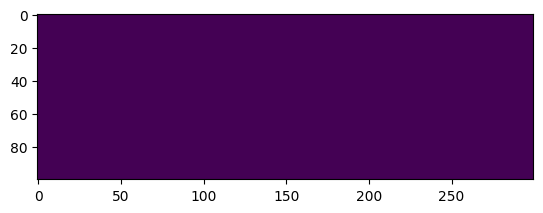

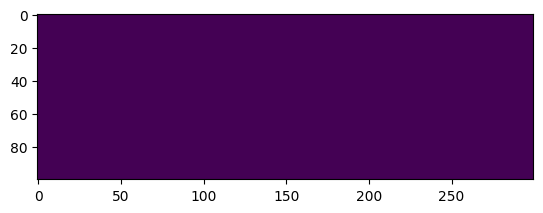

In [3]:
labels = torch.permute(tF.one_hot(slice, num_classes=num_classes), (2, 0, 1))

randperm = torch.randperm(labels.shape[0])
labels = labels[randperm, :, :]

plt.imshow(labels.argmax(dim=0), interpolation='nearest')
plt.show()

for c in range(labels.shape[0]):
    plt.imshow(labels[c], interpolation='nearest')
    plt.show()

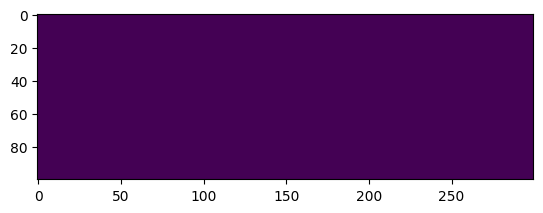

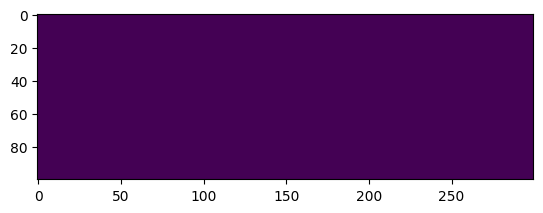

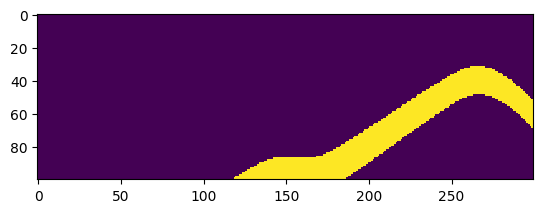

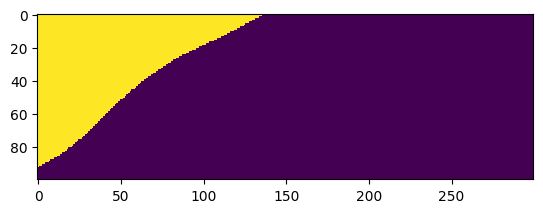

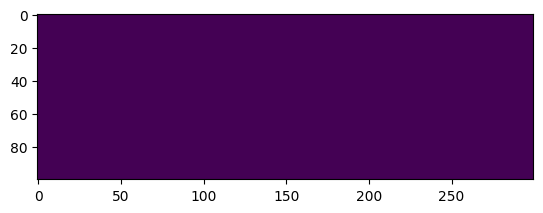

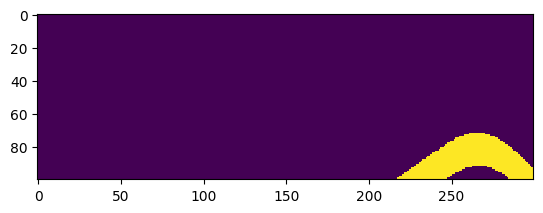

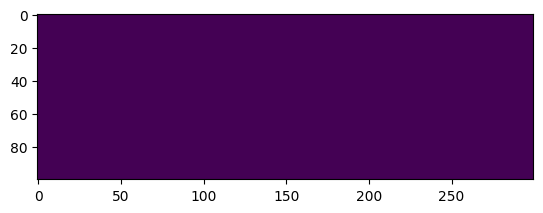

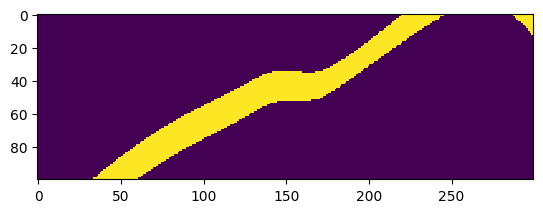

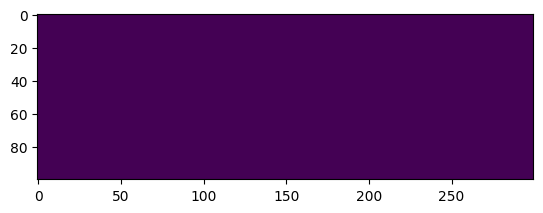

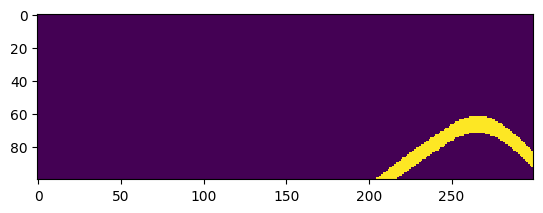

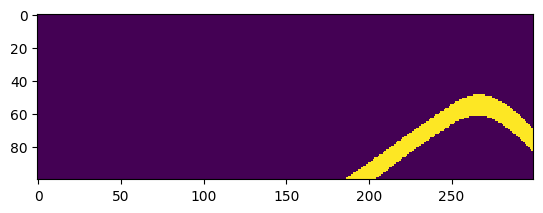

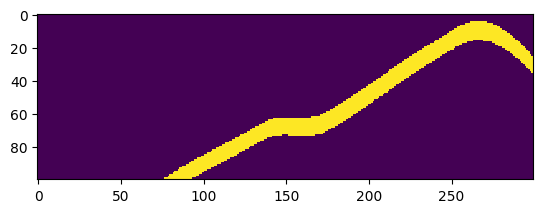

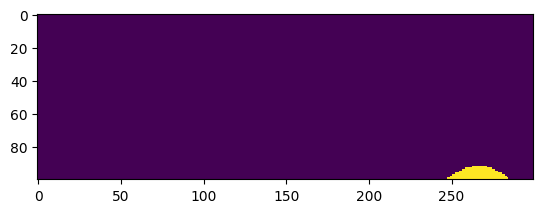

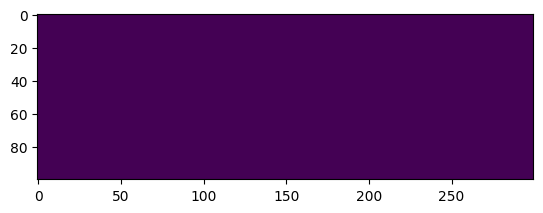

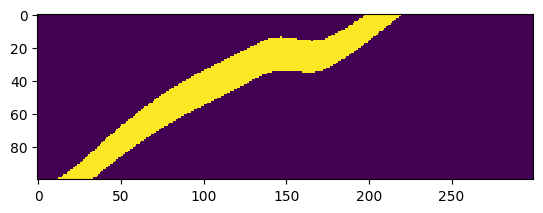

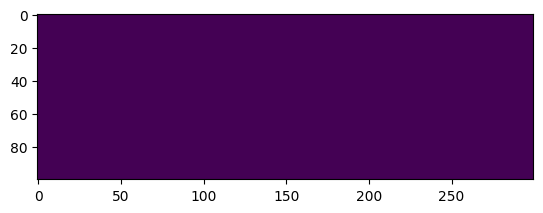

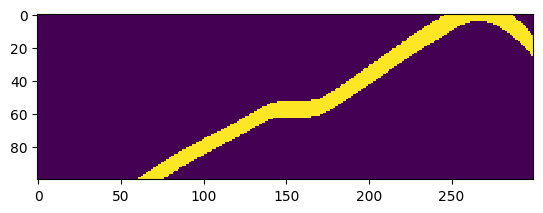

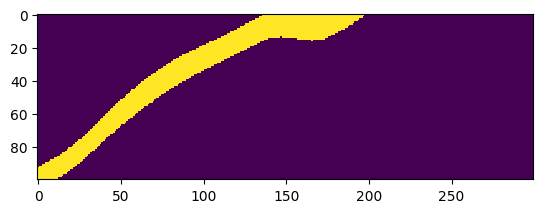

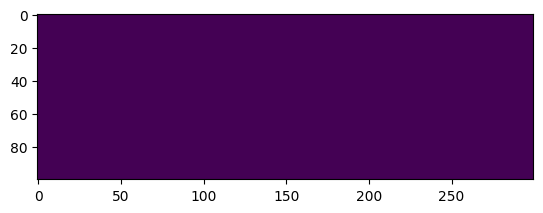

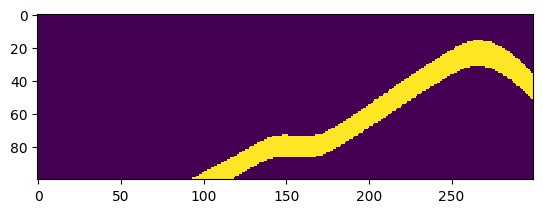

In [4]:
randperm = torch.randperm(labels.shape[0])
outputs = labels[randperm, :, :]

for c in range(outputs.shape[0]):
    plt.imshow(outputs[c], interpolation='nearest')
    plt.show()

In [5]:
similarities = torch.zeros((outputs.shape[0], labels.shape[0]))

for c1 in range(labels.shape[0]):
    for c2 in range(outputs.shape[0]):
        dice = tmF.dice(labels[c1], outputs[c2])
        similarities[c1, c2] = dice
        
indexes = []
for s in range(similarities.shape[0]):
    is_match = False
    similarity = similarities[s]
    
    while not is_match:
        argmax = similarity.argmax().item()
        is_match = similarities[:, argmax].max() == similarity.max()
        
        if is_match and argmax not in indexes:
            indexes.append(argmax)
        else:
            similarity[argmax] = -1
            is_match = False
    
print(indexes)

[2, 0, 17, 3, 12, 1, 4, 5, 11, 10, 6, 19, 16, 7, 8, 9, 13, 14, 15, 18]


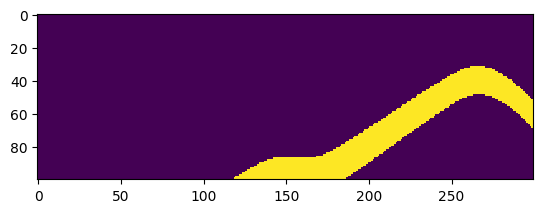

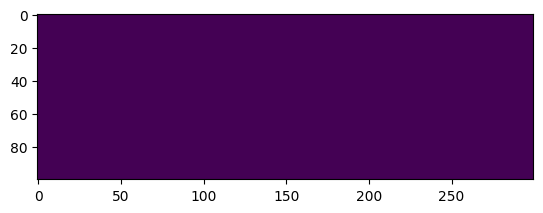

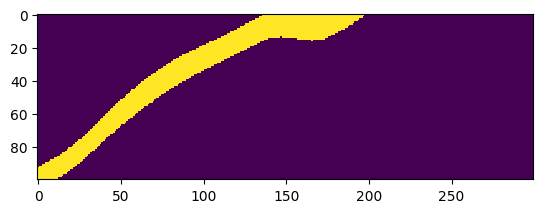

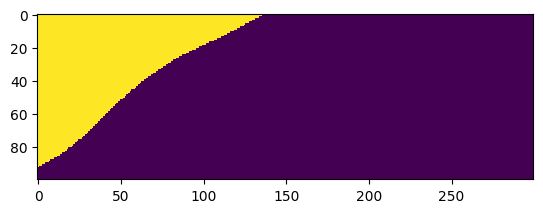

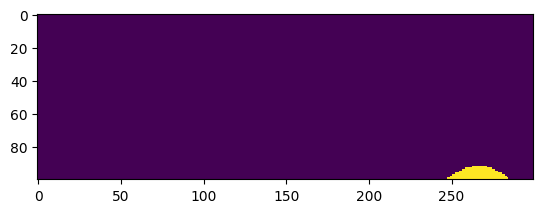

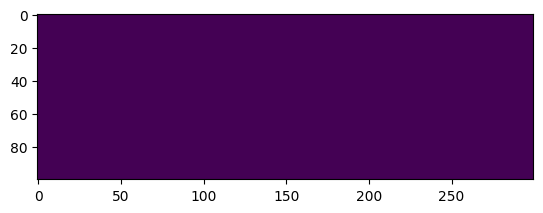

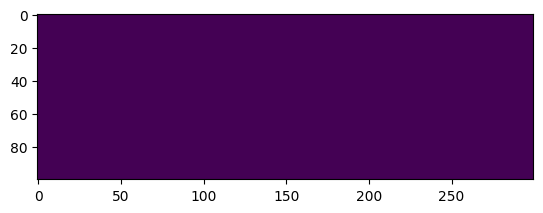

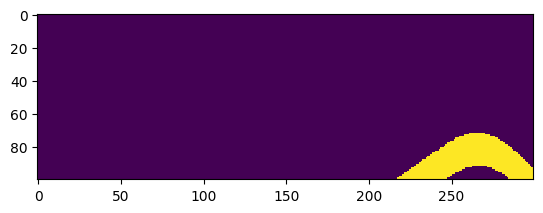

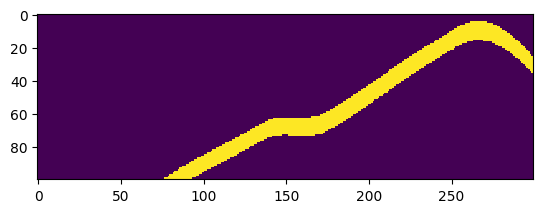

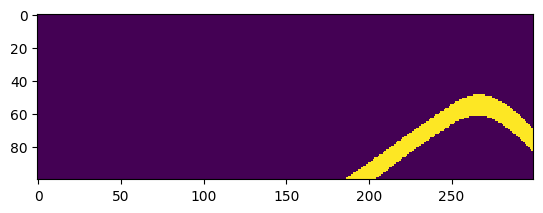

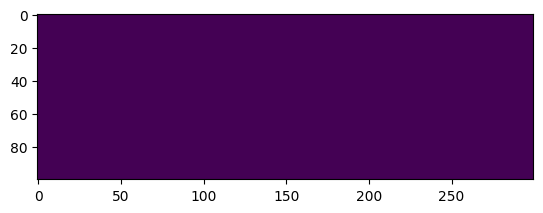

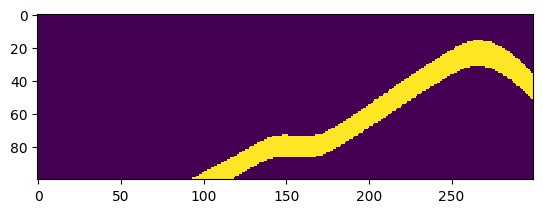

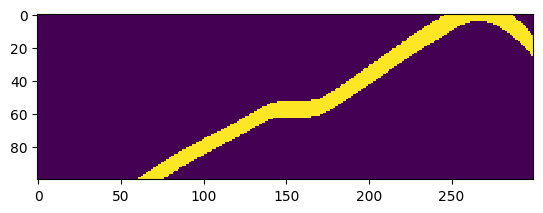

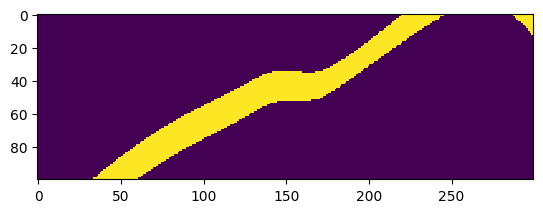

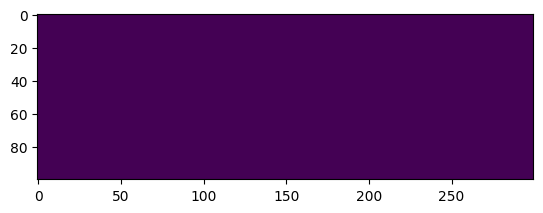

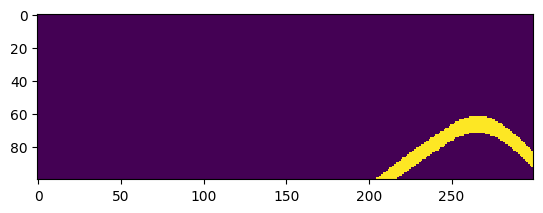

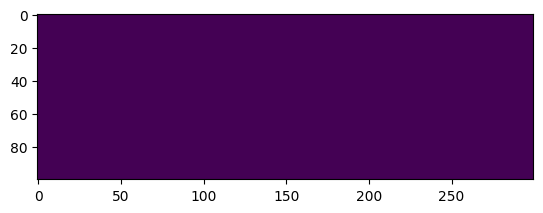

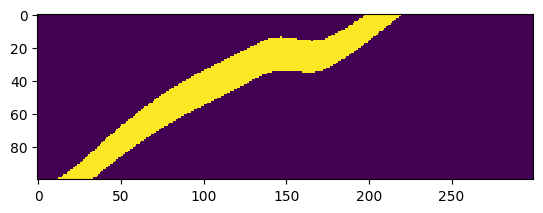

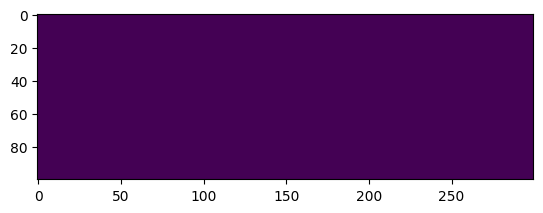

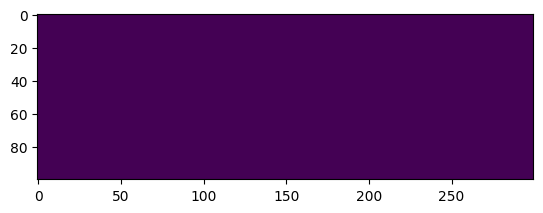

In [6]:
outputs_reordered = outputs[indexes, :, :]

for c in range(outputs_reordered.shape[0]):
    plt.imshow(outputs_reordered[c], interpolation='nearest')
    plt.show()

BEFORE:


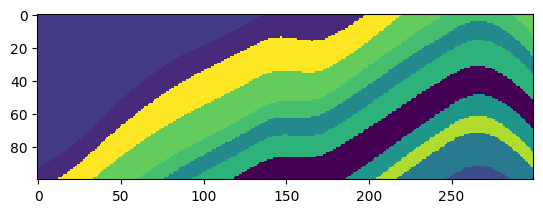

AFTER:


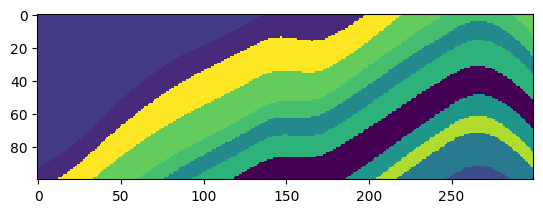

In [9]:
print('BEFORE:')
plt.imshow(labels.argmax(dim=0), interpolation='nearest')
plt.show()

print('AFTER:')
plt.imshow(outputs_reordered.argmax(dim=0), interpolation='nearest')
plt.show()